In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


tqdm.pandas()

In [15]:
# 열 이름 설정
column_names = ['Timestamp', 'ID', 'Length', 'Data1', 'Data2', 'Data3', 'Data4', 
                'Data5', 'Data6', 'Data7', 'Data8', 'label']

df = pd.read_csv('/Users/hongjiu/Desktop/p/CHD/Fuzzy_dataset.csv', names=column_names, dtype={'Timestamp': str})

# 데이터 확인
print(f"Row: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()

# 'R', 'T'를 label로 이동, 나머지는 결측값 처리
for col in column_names[3:-1]:  # 'Data1'부터 'Data8'까지 반복
    df['label'] = np.where(df[col].isin(['R', 'T']), df[col], df['label'])
    df[col] = np.where(df[col].isin(['R', 'T']), np.nan, df[col])
    df['label'] = df['label'].apply(lambda x: 0 if x == 'R' else (1 if x == 'T' else x))


Row: 3838860, Columns: 12


In [16]:
# 데이터 확인
print(f"Row: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()

Row: 3838860, Columns: 12


,Timestamp,ID,Length,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1478195721.903877,0545,8,d8,00,00,8a,00,00,00,00,0.0
1,1478195721.905736,02b0,5,ff,7f,00,05,49,NaN,NaN,NaN,0.0
2,1478195721.908437,0002,8,00,00,00,00,00,01,07,15,0.0
3,1478195721.908676,0153,8,00,21,10,ff,00,ff,00,00,0.0
4,1478195721.909414,0130,8,19,80,00,ff,fe,7f,07,60,0.0


In [17]:
# 결측값을 -1로 대체
data_columns = column_names[3:-1]  # 'Data1'부터 'Data8'까지 선택
df[data_columns] = df[data_columns].fillna(-1)

# Timestamp 변환 및 시간 차이 계산
df['Timestamp'] = df['Timestamp'].astype(float)
df['Timestamp'] = df['Timestamp'].diff().fillna(0).round(6) * 1e6  
df['Timestamp'] = df['Timestamp'].astype(int)

In [18]:
# ID를 16진수 → 2진수 문자열로 변환
df['ID'] = df['ID'].apply(lambda x: bin(int(x, 16))[2:].zfill(16) if isinstance(x, str) else x)

# 결과 출력
# 3. ID 라벨 인코딩
label_encoder = LabelEncoder()
df['ID'] = label_encoder.fit_transform(df['ID'])
# 데이터 확인
df.head()

,Timestamp,ID,Length,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0,1349,8,d8,00,00,8a,00,00,00,00,0.0
1,1859,688,5,ff,7f,00,05,49,-1,-1,-1,0.0
2,2701,2,8,00,00,00,00,00,01,07,15,0.0
3,239,339,8,00,21,10,ff,00,ff,00,00,0.0
4,738,304,8,19,80,00,ff,fe,7f,07,60,0.0


In [19]:
col = ['Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8']

for i in col:
    df[i] = df[i].apply(lambda x: int(x, 16) if type(x)==str else x)
    
df[col] = df[col].fillna(-1)

In [20]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'R' else (1 if x == 'T' else x))

In [21]:
def data_preprocessing(df):
    tqdm.pandas()  # tqdm 적용

    # 2. 결측값을 -1로 대체
    data_columns = [f'Data{i}' for i in range(1, 9)]
    df[data_columns] = df[data_columns].fillna(-1)

    # 3. Timestamp 변환 및 시간 차이 계산
    df['Timestamp'] = df['Timestamp'].astype(float)
    df['Timestamp'] = df['Timestamp'].diff().fillna(0).round(6) * 1e6  
    df['Timestamp'] = df['Timestamp'].astype(int)

    # 4. ID를 16진수 → 2진수 문자열 변환 후 라벨 인코딩
    df['ID'] = df['ID'].apply(lambda x: bin(int(x, 16))[2:].zfill(16) if isinstance(x, str) else x)
    label_encoder = LabelEncoder()
    df['ID'] = label_encoder.fit_transform(df['ID'])

    # 5. Data 필드 16진수를 정수로 변환
    for col in data_columns:
        df[col] = df[col].apply(lambda x: int(x, 16) if isinstance(x, str) else x)


    return df

In [22]:
from sklearn.model_selection import train_test_split

# 1. 데이터셋 분할 (Train: 64%, Validation: 16%, Test: 20%)
train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=42)

# 2. 학습, 검증, 테스트 라벨 분리
train_y = train.pop('label')
val_y = val.pop('label')
test_y = test.pop('label')

In [23]:
# df.drop(columns=['label'], inplace=True)
# test.drop(columns=['label'], inplace=True)

In [24]:
df.head()

,Timestamp,ID,Length,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0,1349,8,216,0,0,138,0,0,0,0,0.0
1,1859,688,5,255,127,0,5,73,-1,-1,-1,0.0
2,2701,2,8,0,0,0,0,0,1,7,21,0.0
3,239,339,8,0,33,16,255,0,255,0,0,0.0
4,738,304,8,25,128,0,255,254,127,7,96,0.0


In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 3. 데이터 스케일링 (훈련 데이터 기준으로 fit)
scaler = StandardScaler()
train_X = scaler.fit_transform(train)  # 훈련 데이터에 대해 fit & transform
val_X = scaler.transform(val)  # 검증 데이터 변환 추가
test_X = scaler.transform(test)  # 테스트 데이터 변환 추가

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# 4. CNN 모델을 위한 데이터 형태 변환
train_X = train_X.reshape(-1, train_X.shape[1], 1).astype(np.float32)
val_X = val_X.reshape(-1, val_X.shape[1], 1).astype(np.float32)
test_X = test_X.reshape(-1, test_X.shape[1], 1).astype(np.float32)

train_y = train_y.values.astype(np.float32)
val_y = val_y.values.astype(np.float32)
test_y = test_y.values.astype(np.float32)

# ✅ 5. 1D CNN 모델 정의
model = Sequential([
    Input(shape=(train_X.shape[1], 1)),
    
    Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding='same'),
    
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding='same'),

    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# ✅ 6. 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# ✅ 7. EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ 8. 모델 학습 (훈련 데이터 & 검증 데이터 사용)
history = model.fit(
    train_X, train_y,
    epochs=50,
    batch_size=64,
    validation_data=(val_X, val_y),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.9962 - loss: 0.0279 - val_accuracy: 0.9999 - val_loss: 0.0018
Epoch 2/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 9.2221e-04
Epoch 3/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.9999 - loss: 6.8855e-04 - val_accuracy: 0.9999 - val_loss: 6.7973e-04
Epoch 4/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.9999 - loss: 5.1007e-04 - val_accuracy: 1.0000 - val_loss: 3.4276e-04
Epoch 5/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.9999 - loss: 4.0125e-04 - val_accuracy: 1.0000 - val_loss: 3.5506e-04
Epoch 6/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.9999 - loss: 3.6205e-04 - val_accuracy: 1.0000 - val_loss: 4.4379e-04
Epoch 7/50
38389/38389 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 1.0000 - loss: 3.1450e-04 - val_accuracy: 1.0000 - val_loss: 7.7295e-04
Epoch 8/50
38389/38389 ━━

76778/76778 ━━━━━━━━━━━━━━━━━━━━ 33s 428us/step
훈련 데이터 평가
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2142088
         1.0       1.00      1.00      1.00    314782

    accuracy                           1.00   2456870
   macro avg       1.00      1.00      1.00   2456870
weighted avg       1.00      1.00      1.00   2456870

19195/19195 ━━━━━━━━━━━━━━━━━━━━ 8s 415us/step
검증 데이터 평가
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    535522
         1.0       1.00      1.00      1.00     78696

    accuracy                           1.00    614218
   macro avg       1.00      1.00      1.00    614218
weighted avg       1.00      1.00      1.00    614218

23993/23993 ━━━━━━━━━━━━━━━━━━━━ 10s 413us/step
테스트 데이터 평가
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    669403
         1.0       1.00      1.00      1.00     98369

    accu

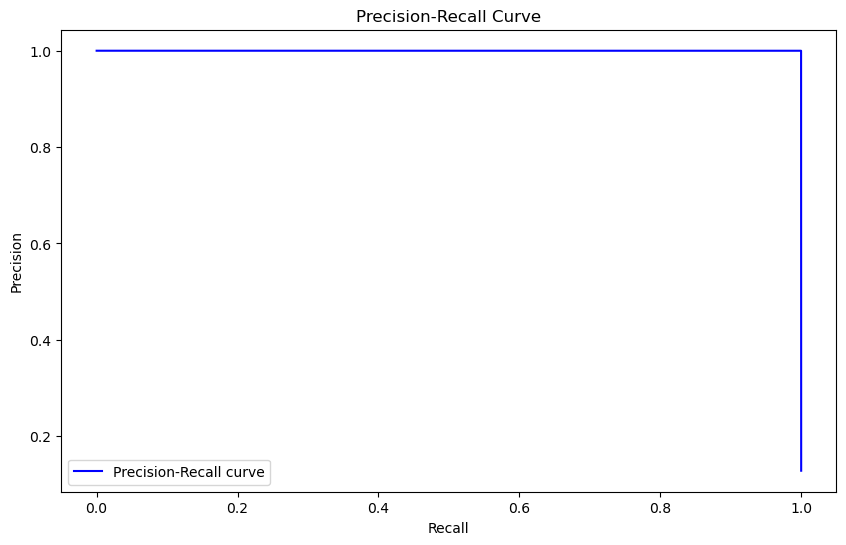

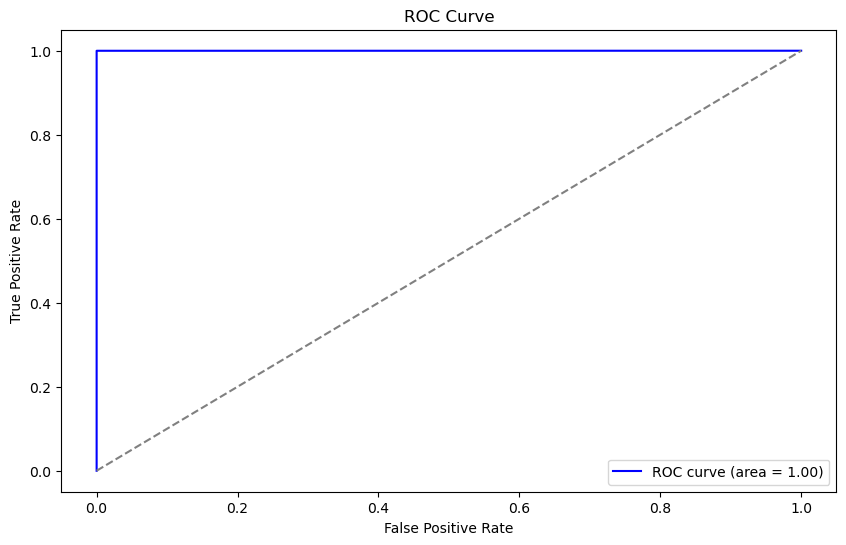

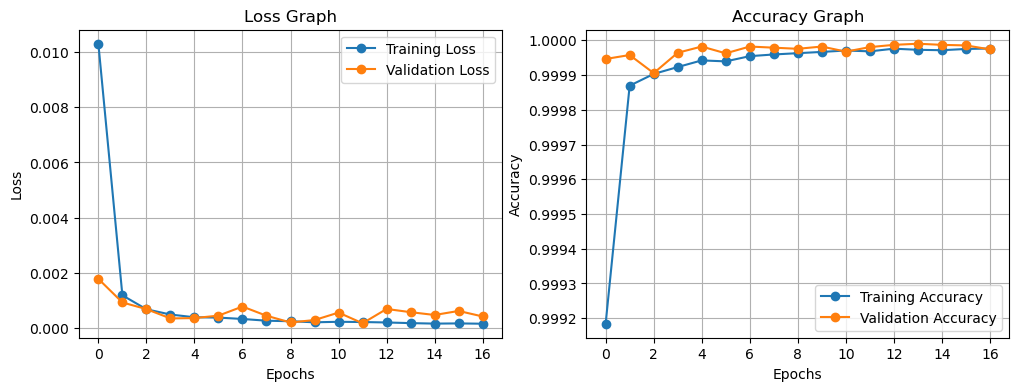

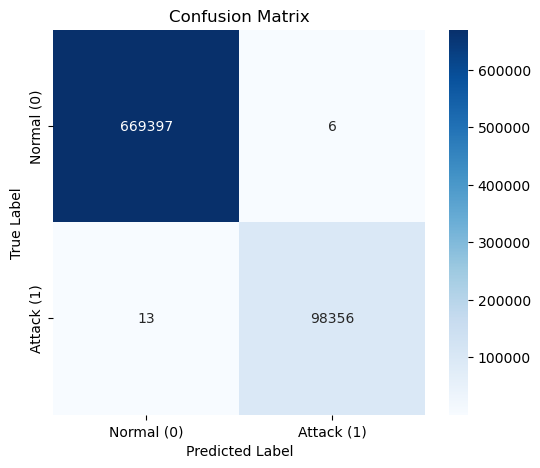

In [27]:
# ✅ 9. 훈련 데이터 평가
train_pred = (model.predict(train_X) > 0.5).astype(int)
print("훈련 데이터 평가")
print(classification_report(train_y, train_pred, zero_division=1))

# ✅ 10. 검증 데이터 평가
val_pred = (model.predict(val_X) > 0.5).astype(int)
print("검증 데이터 평가")
print(classification_report(val_y, val_pred, zero_division=1))

# ✅ 11. 테스트 데이터 평가
test_pred = (model.predict(test_X) > 0.5).astype(int)
print("테스트 데이터 평가")
print(classification_report(test_y, test_pred, zero_division=1))

# ✅ 12. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_y, test_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# ✅ 13. ROC Curve
fpr, tpr, _ = roc_curve(test_y, test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# ✅ 14. 학습 과정 시각화 함수
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# ✅ 15. 오차 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Attack (1)'], yticklabels=['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# ✅ 16. 손실 및 정확도 그래프 출력
plot_training_history(history)

# ✅ 17. 테스트 데이터 오차 행렬 출력
plot_confusion_matrix(test_y, test_pred.astype(int))